In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
pwd

'/Users/agne/Documents/Interview tasks/Vinted'

## 1. Load the data

Code below allows access to all data folders subsequently, imports and concatinates separate json files in each data folder into one. All data is written into a dictionary and separate data frames can be accessed through d[name].

Before coming up with this code, I tested my method by:
- importing json files from any given data folder separately to explore the amount of variables and observations,
- exploring any duplicate tracking codes or transaction_id's I need to be aware of.

Only after familiarizing with the data, I wrote the universal import code.

In [3]:
d = {}
for name in ['product_invoices', 'product_package_types', 'product_shipments', 'provider_invoices', 'provider_prices']:
    path = r'Data/%s'%name 
    all_files = glob.glob(path + "/*.json")

    li = []

    for filename in all_files:
        df = pd.read_json(filename, lines=True)
        li.append(df)

    d[name] = pd.concat(li, axis=0, ignore_index=True)

## 2. Quickly explore and transform the data to a python data frame

In addition, explore and fix any:
- missing values,
- duplicate IDs
- unusual data types.

In addition, where it is quick and potentially useful for future analysis, I engineer some variables into numeric types and deal with some datetime types to ease future analysis.

In [4]:
def summaries(df, idvar):
    print(d[df].info())    
    print('\n')
    print('# duplicates: ', d[df].duplicated().sum())
    print('ID duplicates: ', d[df].duplicated(idvar).sum())
    print('# missing values: ', d[df].isnull().sum())
    print('\n')

### 2.1 Product invoices

In [5]:
summaries('product_invoices', 'transaction_id')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554038 entries, 0 to 554037
Data columns (total 3 columns):
transaction_id       554038 non-null int64
amount               554038 non-null float64
user_invoice_date    554038 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 12.7+ MB
None


# duplicates:  0
ID duplicates:  0
# missing values:  transaction_id       0
amount               0
user_invoice_date    0
dtype: int64




In [6]:
product_invoices = d['product_invoices']

In [7]:
product_invoices['user_invoice_date'] = pd.to_datetime(product_invoices['user_invoice_date']).dt.date

### 2.2 Product package types

In [8]:
summaries('product_package_types', 'id')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
id             134 non-null int64
description    134 non-null object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None


# duplicates:  0
ID duplicates:  0
# missing values:  id             0
description    0
dtype: int64




In [9]:
product_package_types = d['product_package_types']

### 2.3 Product shipments

In [11]:
summaries('product_shipments', 'transaction_id') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562886 entries, 0 to 562885
Data columns (total 8 columns):
tracking_code             562886 non-null int64
from_country              562886 non-null object
to_country                562886 non-null object
package_type_id           562886 non-null int64
transaction_id            562886 non-null int64
shipping_label_created    562886 non-null object
buyer_id                  562886 non-null int64
seller_id                 562886 non-null int64
dtypes: int64(5), object(3)
memory usage: 34.4+ MB
None


# duplicates:  0
ID duplicates:  0
# missing values:  tracking_code             0
from_country              0
to_country                0
package_type_id           0
transaction_id            0
shipping_label_created    0
buyer_id                  0
seller_id                 0
dtype: int64




In [12]:
product_shipments = d['product_shipments']

In [13]:
product_shipments['shipping_label_created_date'] = pd.to_datetime(product_shipments['shipping_label_created']).dt.date

### 2.4 Provider prices

In [14]:
#provider prices does not have a designated ID; however it is uniquely identified by all variables, as the individual 
#product is the defined by origin/destination country and package_size
summaries('provider_prices', ['from_country', 'to_country', 'actual_package_size'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
from_country           144 non-null object
to_country             144 non-null object
price                  144 non-null float64
actual_package_size    144 non-null object
dtypes: float64(1), object(3)
memory usage: 4.6+ KB
None


# duplicates:  0
ID duplicates:  0
# missing values:  from_country           0
to_country             0
price                  0
actual_package_size    0
dtype: int64




In [15]:
provider_prices = d['provider_prices']

Seeing as the actual_package_size variable is a string, create a numeric option in case it is useful to compare for package size discrepancies between the shipping agent and Vinted.

In [16]:
provider_prices['actual_package_size'].unique()

array(['0.5 kg', '1 kg', '2 kg', '3 kg', '5 kg', '7 kg', '10 kg', '15 kg',
       '30 kg'], dtype=object)

In [17]:
provider_prices['actual_package_size_num'] = provider_prices['actual_package_size'].str.extract("([-+]?\d*\.\d+|[-+]?\d+)").astype(float)

### 2.5 Provider invoices

In [18]:
summaries('provider_invoices', 'tracking_code')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562943 entries, 0 to 562942
Data columns (total 5 columns):
tracking_code      562943 non-null int64
from_country       562943 non-null object
to_country         562943 non-null object
weight_measured    559610 non-null float64
amount             562943 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 21.5+ MB
None


# duplicates:  0
ID duplicates:  2
# missing values:  tracking_code         0
from_country          0
to_country            0
weight_measured    3333
amount                0
dtype: int64




In [19]:
provider_invoices = d['provider_invoices']

There is a tracking code duplicate in the provider invoices dataframe. This means there should be a duplicate in the product_shipments dataframe too.

Below, I investigate the problem.

In [20]:
provider_invoices[provider_invoices.duplicated('tracking_code')]

,tracking_code,from_country,to_country,weight_measured,amount
438953,12795958,FR,FR,NaN,3.28
479966,12878564,FR,FR,NaN,3.28


In [21]:
print(provider_invoices[provider_invoices['tracking_code']==12795958])
print(provider_invoices[provider_invoices['tracking_code']==12878564])

        tracking_code from_country to_country  weight_measured  amount
174586       12795958           ES         FR              0.0    3.73
438953       12795958           FR         FR              NaN    3.28
        tracking_code from_country to_country  weight_measured  amount
290553       12878564           ES         FR              0.0    3.73
479966       12878564           FR         FR              NaN    3.28


In [22]:
product_shipments[product_shipments.duplicated('tracking_code')]

,tracking_code,from_country,to_country,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id,shipping_label_created_date
7354,12795958,ES,FR,135,260812237,2019-02-11 16:54:05,21341323,22008389,2019-02-11
502315,12878564,ES,FR,135,271780177,2019-02-26 12:14:31,11869825,21649195,2019-02-26


In [23]:
product_shipments[product_shipments['tracking_code']==12795958]

,tracking_code,from_country,to_country,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id,shipping_label_created_date
3124,12795958,FR,FR,11,7789938,2015-04-25 20:07:56,1827490,1164460,2015-04-25
7354,12795958,ES,FR,135,260812237,2019-02-11 16:54:05,21341323,22008389,2019-02-11


In [24]:
product_shipments[product_shipments['tracking_code']==12878564]

,tracking_code,from_country,to_country,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id,shipping_label_created_date
409079,12878564,FR,FR,11,8638716,2015-05-19 18:50:57,1702596,105141,2015-05-19
502315,12878564,ES,FR,135,271780177,2019-02-26 12:14:31,11869825,21649195,2019-02-26


Looks like the both duplicate cases are a result from mistakenly assigning the same ID to two instances. In fact, the two cases of duplicates seem to mirror each other in both dataframes.

In the following cells, I will reassign one of the duplicates with tracking_code 12795958 to the other duplicates' tracking code 12878564 (in both dataframes). Afterwards, I will drop other remaining cases (with tracking code 12878564).

I assume that I have discussed this case with a superior, who has confirmed my hunch and my solution method (switching tracking numbers in our datasets will not be an issue for the shipping agent).

In [25]:
provider_invoices['tracking_code'] = np.where((provider_invoices['tracking_code'] == 12795958) 
                                             & (provider_invoices['from_country'] == 'ES'), 12878564, provider_invoices['tracking_code'])

product_shipments['tracking_code'] = np.where((product_shipments['tracking_code'] == 12795958) 
                                             & (product_shipments['from_country'] == 'ES'), 
                                                12878564, product_shipments['tracking_code'])

In [26]:
provider_invoices = provider_invoices.drop_duplicates('tracking_code', keep='first')
product_shipments = product_shipments.drop_duplicates('tracking_code', keep='first')

Below I will engineer a weight variable that reflects the weight categories in the shipping agent's price list: 0.5, 1, 2, 3, 5, 7, etc. kg's.

In [27]:
provider_prices['actual_package_size_num'].unique()

array([ 0.5,  1. ,  2. ,  3. ,  5. ,  7. , 10. , 15. , 30. ])

In [28]:
weight = ["0.5", "1", "2", "3", "5", "7", "10", "15", "30"]

provider_invoices['weight_measured_cat'] = pd.cut(x=provider_invoices['weight_measured'], bins=[-1, 499, 999, 1999,
                                                                      2999, 4999, 6999, 
                                                                      9999, 14999, 29999], labels=weight)

provider_invoices['weight_measured_cat'] = np.where(provider_invoices['weight_measured'].isnull()==True, 
                                                0, provider_invoices['weight_measured_cat'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
provider_invoices['weight_measured_cat'] = pd.to_numeric(provider_invoices['weight_measured_cat'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 3. Analysis

Conduct analysis on the basis of the following questions:

1. Are there any discrepancies between the shipping service provider invoices and our invoices to buyers? Can you explain them?

2. What are the key trends you observe in the data over the period for which data is available? What is the business impact of these trends?

3. If you had more time and could ask for more data, how would you continue your analysis to identify and fix shortcomings in the shipping/billing process?

### 3.1 Discrepancies between shipping agent's data and Vinted

To analyze the first question, I will investigate what is the underlying reason why some product and provider datasets have less transactions than others.

Then, I will merge all information Vinted has on transactions to compare it with the information available from the shipping service provider.

Immediately, it can be seen that the only basis we can compare Vinted and shipping vendors' data on a transaction is the amount per transaction.

In [30]:
#merge all information on transactions on Vinted's side.
product = pd.merge(right=product_invoices, left=product_shipments, on='transaction_id', how='inner')
product.head()

,tracking_code,from_country,to_country,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id,shipping_label_created_date,amount,user_invoice_date
0,16065872,FR,FR,10,51939522,2017-07-01 18:06:50,12146205,12167488,2017-07-01,2.40,2017-07-07
1,33418749,FR,FR,12,206013154,2018-11-17 21:30:13,8102264,17675977,2018-11-17,3.15,2018-12-01
2,15596730,FR,FR,11,46161560,2017-05-12 12:44:49,11481074,12701905,2017-05-12,2.73,2017-05-19
3,30712952,FR,FR,11,182803213,2018-10-14 20:23:30,1864654,10428090,2018-10-14,2.73,2018-10-23
4,31187151,FR,FR,11,187579007,2018-10-21 19:59:31,13944144,7327476,2018-10-21,2.73,2018-10-28


In [31]:
#The number of observations in product_invoices and product_shipments dataframes is different
print('Number of shipments with uncollected shipping payments:', product_shipments.shape[0] - product_invoices.shape[0])

Number of shipments with uncollected shipping payments: 8846


In [32]:
#create a merge dataframe to compare information between Vinted and the shipping agent
merged = pd.merge(right=provider_invoices, left=product, on='tracking_code', how='outer', indicator=True,
                 suffixes=('_prov', '_vinted' ))

In [33]:
#the provider has not given invoices for 8905 shipments.
merged['_merge'].value_counts()

both          554036
right_only      8905
left_only          0
Name: _merge, dtype: int64

Basic observations:
1. At this point in time, 8,846 shipments have not been payed for by the user.
2. At this point in time, the shiping agent has not provided invoices for 8,905 transactions.

As mentioned above, with available data, the first discrepancy between shipment service provider and Vinted's data that may occur, could be related to the amounts associated with each transaction.

To investigate this, I will create a discrepancy variable - the difference in the amount per transaction provided by the shipping agent and Vinted's records. 

1. For any transaction, if the discrepancy variable is zero - this means that the shipping agent and Vinted's data matches.
2. For any transaction, if the discrepancy variable is <0 - this means that the shipping agent has a smaller amount than Vinted in its records.
3. For any transaction, if the dsicrepancy variable is >0 - this means that the shipping agent has a larger amount than Vinted in its records.

In [34]:
merged['discrepancy'] = merged['amount_prov'] - merged['amount_vinted']

Text(0.5, 1.0, "There are discrepancies in the amounts recorded in shipping agent and Vinted's data")

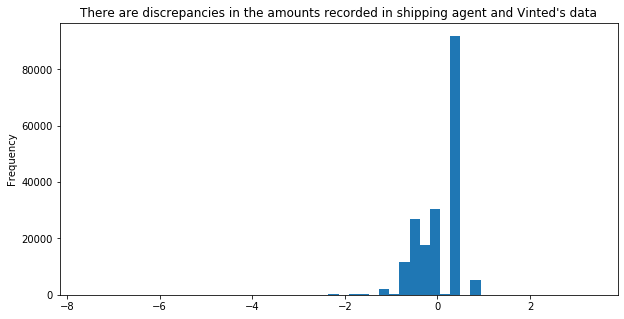

In [35]:
merged[merged['discrepancy']!=0]['discrepancy'].plot(kind='hist', bins=50, figsize=(10,5))
plt.title("There are discrepancies in the amounts recorded in shipping agent and Vinted's data")

There are discrepancies in the transaction amounts between Vinted and the shipping agent's records. In most cases, the discrepancy in reported amounts does not go over one (amount) unit.

Below I investigate, what type of discrepancy is more prevalent.

In [36]:
merged['discrepancy2'] = np.where(merged['discrepancy']<0, -1, 
                                 np.where(merged['discrepancy']>0, 1, 0))

Text(0.5, 1.0, "Amount per transaction wrt Vinted's records")

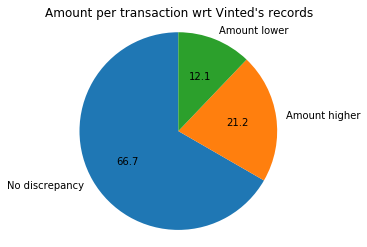

In [37]:
figure, axes = plt.subplots()
three_lab = ("No discrepancy", "Amount higher", "Amount lower")

# Draw the pie chart
axes.pie(merged['discrepancy2'].value_counts(), labels=three_lab, startangle=90, autopct='%1.1f')
axes.axis('equal')

plt.title("Amount per transaction wrt Vinted's records")

In the majority of records, where the shipment agent has provided the invoice, there are no discrepancies in the amounts per transaction.

Vinted's data being constant, in 12.1% cases on record, the amount in the shipping agent's invoice is lower than in Vinted's. In more cases, 21.2%, the amount in sipping agent's invoice is higher than in Vinted's records. 

While this sounds alarming, in the last step will assess if the total of invoices provided by the shipping agent is larger that what Vinted has.

In [38]:
total_amt_vinted = round(merged['amount_vinted'].sum(),2)
total_amt_prov = round(merged['amount_prov'].sum(),2)

print("Total amount Vinted's records: ",total_amt_vinted)
print("Total amount shipment agent's records: ",total_amt_prov)

Total amount Vinted's records:  1488923.77
Total amount shipment agent's records:  1470836.27


However, the total amount in Vinted's records seems to be higher than in the invoices provided by the shipping agent. Thankfully, Vinted will not be surpised by overall larger invoices to cover than anticipated.

Nevertheless, this is a dicrepancy. With more time, a few causes can be investigated:
 - Vinted users enter inacurrate parcel size details upon checkout.
 - shipping prices stored in Vinted's database are outdatted.
 - there is a mistake in the code that generates shipping prices for a given parcel.
 - the shipping agent does not treat all shipping cases uniformally (i.e, charges inconsistent amounts to similar sized packages).

### 3.2 Key trends in data

1. Engineer a full transacted and payed-for product dataset.
2. Generate internal summary stats: number of customers (unique, unique buyers, unique sellers), time between shipping label and invoice date, type of packages, most popular route, popular destination-origin country.
3. Run a quick test on how consistent with their pricing have the shippers been.

In [39]:
product_final = pd.merge(left=product, right=product_package_types, 
                         left_on='package_type_id', right_on='id', how='left')

In [40]:
product_final.head()

,tracking_code,from_country,to_country,package_type_id,transaction_id,shipping_label_created,buyer_id,seller_id,shipping_label_created_date,amount,user_invoice_date,id,description
0,16065872,FR,FR,10,51939522,2017-07-01 18:06:50,12146205,12167488,2017-07-01,2.40,2017-07-07,10,0.5kg
1,33418749,FR,FR,12,206013154,2018-11-17 21:30:13,8102264,17675977,2018-11-17,3.15,2018-12-01,12,2kg
2,15596730,FR,FR,11,46161560,2017-05-12 12:44:49,11481074,12701905,2017-05-12,2.73,2017-05-19,11,1kg
3,30712952,FR,FR,11,182803213,2018-10-14 20:23:30,1864654,10428090,2018-10-14,2.73,2018-10-23,11,1kg
4,31187151,FR,FR,11,187579007,2018-10-21 19:59:31,13944144,7327476,2018-10-21,2.73,2018-10-28,11,1kg


#### 3.2.1 Customers

In [41]:
print("Number of unique buyers: ", product_final['buyer_id'].nunique())
print("Number of unique sellers: ", product_final['seller_id'].nunique())

Number of unique buyers:  360570
Number of unique sellers:  376527


In [42]:
buyers = product['buyer_id'].to_list()
sellers = product['seller_id'].to_list()
customers = buyers + sellers

from collections import Counter
unique = Counter(customers).keys() 
print("Number of unique customers: ", len(unique))

Number of unique customers:  649044


In [43]:
buyers = pd.DataFrame(product_final['buyer_id'])
sellers = pd.DataFrame(product_final['seller_id'])

In [44]:
sb_merge = pd.merge(left=buyers, right=sellers, 
                    left_on='buyer_id', right_on='seller_id', how='outer', indicator=True)

Text(0.5, 1.0, 'Types of customers')

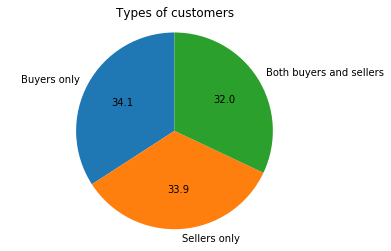

In [45]:
figure, axes = plt.subplots()
three_lab = ("Buyers only", "Sellers only", "Both buyers and sellers")

# Draw the pie chart
axes.pie(sb_merge['_merge'].value_counts(), labels=three_lab, startangle=90, autopct='%1.1f')
axes.axis('equal')

plt.title("Types of customers")

Vinted's customers during this period can be divided to three nearly equal groups: Buyers-only, sellers-only and both buyers and sellers.

#### 3.2.2 Shipping label and user invoice dates

In [46]:
product_final['user_invoice_date'] = pd.to_datetime(product_final['user_invoice_date']).dt.date
product_final['time_elapsed'] = pd.to_datetime(product_final['user_invoice_date'] - product_final['shipping_label_created_date']).dt.day

/usr/local/lib/python3.7/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


Text(0.5, 1.0, 'Time elapsed between shipping label and user invoice (days)')

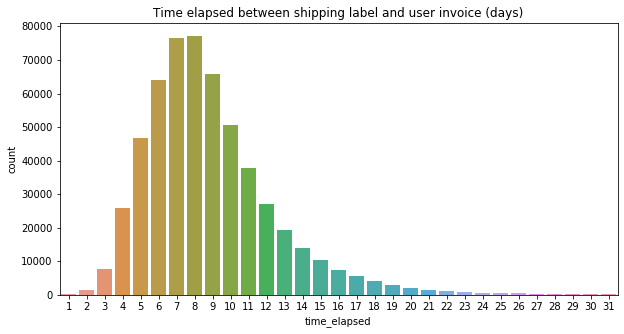

In [47]:
plt.figure(figsize=(10,5))
sb.countplot(data=product_final, x='time_elapsed')
plt.title('Time elapsed between shipping label and user invoice (days)')

In [48]:
print("Average time until user invoice after shipping label is ready:", round(product_final['time_elapsed'].mean(),1), "days")
print("Minimum time until user invoice after shipping label is ready:", product_final['time_elapsed'].min(), "days")
print("Maximum time until user invoice after shipping label is ready:", product_final['time_elapsed'].max(), "days")

Average time until user invoice after shipping label is ready: 8.8 days
Minimum time until user invoice after shipping label is ready: 1 days
Maximum time until user invoice after shipping label is ready: 31 days


In [49]:
pd.DataFrame(product_final.groupby(by=['from_country','to_country'])['time_elapsed'].mean())

time_elapsed
from_country to_country              
BE           BE              8.065693
             ES             10.500000
             FR              9.210449
             LU              6.000000
ES           BE             10.916667
             ES             11.611111
             FR             11.086622
             LU              9.000000
FR           BE              9.519797
             ES             10.772643
             FR              8.814786
             LU              9.600000
LU           FR             10.250000

Average time it takes to generate a shipping label after user invoice is 8.8 days. The average, however varies depending on the shipping route.

The average time until a shipping label is generate is the shortest for the Belgium-Lithuania shipments, 6 days. The longest - for shipments within Spain, 11.6 days.

#### 3.2.3 Type of packages

In [50]:
pd.DataFrame(product_final['description'].value_counts()/len(product_final)*100)

,description
0.5kg,47.512075
1kg,33.724704
2kg,18.740840
5kg,0.014800
10kg,0.004151
20kg,0.003429


Most packages are small, with the majority being up to 500 grams (47.5%). Larger packages of 5kgs and more make up about 2% of the total packages in the data.

#### 3.2.4 Origin and destination

In [51]:
product_final['from_to'] = product_final['from_country'] + "-" + product_final['to_country']
pd.DataFrame(product_final['from_to'].value_counts()/len(product_final)*100)

,from_to
FR-FR,97.845266
BE-FR,0.981164
FR-BE,0.816012
ES-FR,0.187533
FR-ES,0.097647
BE-BE,0.049455
ES-BE,0.006498
ES-ES,0.006498
BE-ES,0.004693
FR-LU,0.002707


I investigated where do most packages are getting shipped. In the current period, within France shipments dominate (97.8%). Other origin-destination combinations do not make up a share larger than 1%.

#### 3.2.5 Discrepancies in amounts invoiced by shipper

In an earlier exercise, one reason for frequent discrepancies in the amount per package in Vinted's data and shipper's invoices can be that the shipper charges inconsistently. 

With data available (and new variables engineered earlier), it is possible to roughly investigate whether there are any stricking mismatches between amounts charged for certain packages in the invoice and the prices for same-sized packages in the shipper's price list.

In [52]:
#Code below merges the shipper's invoice with the shipper's price list on route and weight of the package
#only investigate prices that occur in the invoice from the current period.
provider_final = pd.merge(left=provider_invoices, right=provider_prices, 
                         left_on=['from_country', 'to_country', 'weight_measured_cat'], 
                          right_on=['from_country', 'to_country', 'actual_package_size_num'], how='inner')

In [53]:
provider_final[provider_final['amount']!=provider_final['price']][['amount', 'weight_measured', 'price', 'actual_package_size']]

,amount,weight_measured,price,actual_package_size
3,2.73,0.0,2.40,0.5 kg
10,2.73,0.0,2.40,0.5 kg
13,2.73,0.0,2.40,0.5 kg
16,2.73,0.0,2.40,0.5 kg
20,2.73,0.0,2.40,0.5 kg
...,...,...,...,...
559591,4.15,2020.0,5.04,3 kg
559593,4.15,2040.0,5.04,3 kg
559601,2.40,520.0,2.73,1 kg
559604,2.73,1000.0,3.15,2 kg


A basic filter applied on the data shows that there are at least 106K packages where for the same package weight category and route prices are not matching the price list. Below, I assess in how many cases, the the amount in the shipper's invoice is larger than expected (and when it is lower than expected) based on their price list.

In [54]:
provider_final['price_discrepancy'] = np.where(provider_final['amount'] - provider_final['price'] > 0,1, 
                                               np.where(provider_final['amount'] - provider_final['price'] <0, -1,0))

Text(0, 0.5, 'Percentage share')

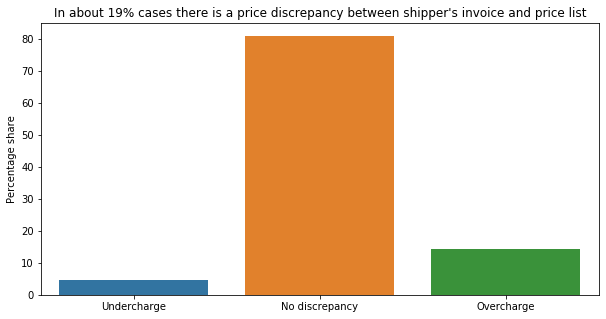

In [55]:
plt.figure(figsize=(10,5))
sb.barplot(x='price_discrepancy', y='price_discrepancy', data=provider_final, 
           estimator=lambda x: len(x) / len(provider_final) * 100)
plt.title("In about 19% cases there is a price discrepancy between shipper's invoice and price list")
plt.xticks([0,1,2],['Undercharge', 'No discrepancy', 'Overcharge'])
plt.xlabel('')
plt.ylabel('Percentage share')

In about 19% cases with matching route and weight, the shipper's amount in their invoice does not match their price list. 

This conclusion, could be brought up to shipping partners, however, it is not definitive and additional infomation could be useful to confirm it. For example, weighted_measure data in the shipper's invoices contained unusual values, such as 0, and if there was added information as to why, that could potentially teach how to read the shipper's data. 

In addition, with more time, one could extract approximate timing of the shipment information from available product data and see if there aleeged overcharging may be a result of some extra package handling fees during busier postal months.

Finally, there could be some missing data about whether the shipper either re-measured a package (and did not update the invoice records), or had to add to the packaging, which is an extra service. 

### 3.3 How to continue the analysis

With more time I would revisit the question on the discrepancies between Vinted and the shipping service providers' invoices. 

In particular, I would revisit the posibility of Vinted customers inputing inacurate measurements and weight of their packages (if that is a possibility). Data that could be useful for it could be any web-srapped data on user's behavior upon requesting and finalizing shipping details on the page (if possible, how many times they changed the inputs, ir how long it took them to finalize the booking process) and use it in combination with exisiting data to calculate the likelihood there will be a missmatch in our and the shipper's invoice data.

With more time I would dig deeper into the available product data and attempt to re-engineer the amount for the package by using available internal information on the package size and route, and compare that to the amount that is already in the data.

Finally, with more time I would look into the potential issue with the way the shipping agent calculates its prices as it was done just above, only with more attention to the magnitude of price mismatches. I would also try to create some clusters of similar discrepancy (discrepancy in a similar monetatry amount) cases to see if they have anything in common.

Additional data that could be helpful for a meningful business analysis would be more date variables dates when sales are finalized, dates of dispach, etc. 